In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

In [278]:
data = pd.read_csv("../charlotte_preprocessed.csv")


In [279]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11765 entries, 0 to 11764
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   period_begin             11765 non-null  object 
 1   period_end               11765 non-null  object 
 2   region                   11765 non-null  int64  
 3   state_code               11765 non-null  object 
 4   median_sale_price        11765 non-null  float64
 5   homes_sold               11765 non-null  int64  
 6   inventory                11765 non-null  float64
 7   median_dom               11765 non-null  float64
 8   avg_sale_to_list         11765 non-null  float64
 9   sold_above_list          11765 non-null  float64
 10  off_market_in_two_weeks  11765 non-null  float64
 11  median_sale_price_mom    11765 non-null  float64
 12  median_sale_price_yoy    11765 non-null  float64
 13  homes_sold_mom           11765 non-null  float64
 14  homes_sold_yoy        

In [280]:
data['period_begin'] = pd.to_datetime(data['period_begin'])
df = data.sort_values('period_begin').reset_index(drop=True)

In [281]:
data = pd.get_dummies(data, columns=['region'], drop_first=True)


In [282]:
features = [
    'homes_sold', 'inventory', 'median_dom', 
    'off_market_in_two_weeks', 'avg_sale_to_list', 'sold_above_list',
    'median_sale_price_mom', 'median_sale_price_yoy',
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy',
    'year', 'state_NC', 'covid_era',
    'Q_1', 'Q_2', 'Q_3', 'Q_4'
]
target = 'log_price'



In [283]:
def evaluate_regression_model(y_true, y_pred_log):
    r2 = r2_score(y_true, y_pred_log)
    y_true_price = np.exp(y_true)
    y_pred_price = np.exp(y_pred_log)
    mae_price = mean_absolute_error(y_true_price, y_pred_price)
    rmse_price = np.sqrt(mean_squared_error(y_true_price, y_pred_price))
    return r2, mae_price, rmse_price

In [284]:
y_full = data[target]
X_full = data[features]

In [285]:
# Convert any boolean columns (like Q_1, Q_2, etc.) to integers for model compatibility
for col in X_full.select_dtypes(include='bool').columns:
    X_full[col] = X_full[col].astype(int)

/var/folders/bl/4fb7d5n12kn_hx73_tsnfhhc0000gq/T/ipykernel_30989/1750806213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_full[col] = X_full[col].astype(int)
/var/folders/bl/4fb7d5n12kn_hx73_tsnfhhc0000gq/T/ipykernel_30989/1750806213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_full[col] = X_full[col].astype(int)
/var/folders/bl/4fb7d5n12kn_hx73_tsnfhhc0000gq/T/ipykernel_30989/1750806213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [286]:
data.head()

,period_begin,period_end,state_code,median_sale_price,homes_sold,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,...,region_29717,region_29720,region_29726,region_29729,region_29730,region_29732,region_29734,region_29742,region_29743,region_29745
0,2013-02-01,2013-04-30,NC,104000.0,7,24.0,114.0,0.919052,0.142857,0.00,...,False,False,False,False,False,False,False,False,False,False
1,2013-03-01,2013-05-31,NC,80000.0,9,33.0,248.0,0.906982,0.111111,0.00,...,False,False,False,False,False,False,False,False,False,False
2,2013-04-01,2013-06-30,NC,92000.0,10,35.0,168.5,0.909447,0.200000,0.00,...,False,False,False,False,False,False,False,False,False,False
3,2013-05-01,2013-07-31,NC,72000.0,6,33.0,178.5,0.925636,0.333333,0.00,...,False,False,False,False,False,False,False,False,False,False
4,2013-06-01,2013-08-31,NC,90750.0,4,32.0,159.0,0.905654,0.250000,0.08,...,False,False,False,False,False,False,False,False,False,False


In [287]:
# Convert features to a NumPy array for consistent input to models
X_array = X_full.values
feature_names = X_full.columns.values

In [288]:
print(f"Processed feature matrix size: {X_array.shape[1]} features.")

Processed feature matrix size: 21 features.


In [289]:
tscv = TimeSeriesSplit(n_splits=4)

In [298]:
MODELS = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    "XGBoost Regressor": xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=42) 
}

In [291]:
# Get the final train/test split from the last fold of TSCV
train_index, test_index = list(tscv.split(X_array))[-1]
X_train_final, X_test_final = X_array[train_index], X_array[test_index]
y_train_final, y_test_final = y_full.values[train_index], y_full.values[test_index]

# --- 4. Evaluate All Models ---
comparison_results = []
print("Starting final evaluation on the latest out-of-sample test set...")

for name, model in MODELS.items():
    print(f"  Fitting and evaluating {name}...")
    
    model.fit(X_train_final, y_train_final)
    y_pred_log_final = model.predict(X_test_final)
    
    final_r2, final_mae, final_rmse = evaluate_regression_model(y_test_final, y_pred_log_final)
    
    comparison_results.append({
        "Model": name,
        "R2 (log_price)": final_r2,
        "MAE (price)": final_mae,
        "RMSE (price)": final_rmse
    })

# --- 5. Print Comparison Table ---
results_df = pd.DataFrame(comparison_results)
results_df['MAE (price)'] = results_df['MAE (price)'].map('${:,.2f}'.format)
results_df['RMSE (price)'] = results_df['RMSE (price)'].map('${:,.2f}'.format)
results_df = results_df.sort_values(by='R2 (log_price)', ascending=False).reset_index(drop=True)
print("\n--- Comparative Model Evaluation (Latest Out-of-Sample Test Set) ---")
print(results_df.to_markdown(index=False, floatfmt=".4f"))

Starting final evaluation on the latest out-of-sample test set...
  Fitting and evaluating Linear Regression...
  Fitting and evaluating Random Forest Regressor...
  Fitting and evaluating Gradient Boosting Regressor...
  Fitting and evaluating XGBoost Regressor...

--- Comparative Model Evaluation (Latest Out-of-Sample Test Set) ---
| Model                       |   R2 (log_price) | MAE (price)   | RMSE (price)   |
|:----------------------------|-----------------:|:--------------|:---------------|
| Gradient Boosting Regressor |           0.5238 | $46,655.06    | $64,721.74     |
| XGBoost Regressor           |           0.4364 | $50,631.45    | $71,462.83     |
| Random Forest Regressor     |           0.4232 | $49,490.72    | $67,343.18     |
| Linear Regression           |           0.3697 | $54,172.26    | $120,917.24    |


In [292]:
results = {}
best_model_name = ""
best_r2 = -float('inf')

for name, model in MODELS.items():
    print(f"  Evaluating {name}...")
    
    # Use R2 score for cross-validation comparison
    r2_scores = cross_val_score(
        model, 
        X_array, 
        y_full.values, 
        cv=tscv, 
        scoring='r2', 
        n_jobs=-1
    )
    
    mean_r2 = r2_scores.mean()
    results[name] = {'Mean R2': mean_r2, 'R2 Folds': r2_scores}
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_model_name = name

print("\n--- Model Performance Summary (Mean R2 across 4 TimeSeries Folds) ---")
for name, res in results.items():
    print(f"{name}: Mean R2 = {res['Mean R2']:.4f}")
print(f"BEST MODEL: {best_model_name} (Mean R2: {best_r2:.4f})")

  Evaluating Linear Regression...
  Evaluating Random Forest Regressor...
  Evaluating Gradient Boosting Regressor...
  Evaluating XGBoost Regressor...

--- Model Performance Summary (Mean R2 across 4 TimeSeries Folds) ---
Linear Regression: Mean R2 = 0.3660
Random Forest Regressor: Mean R2 = 0.3474
Gradient Boosting Regressor: Mean R2 = 0.4393
XGBoost Regressor: Mean R2 = 0.4066
BEST MODEL: Gradient Boosting Regressor (Mean R2: 0.4393)


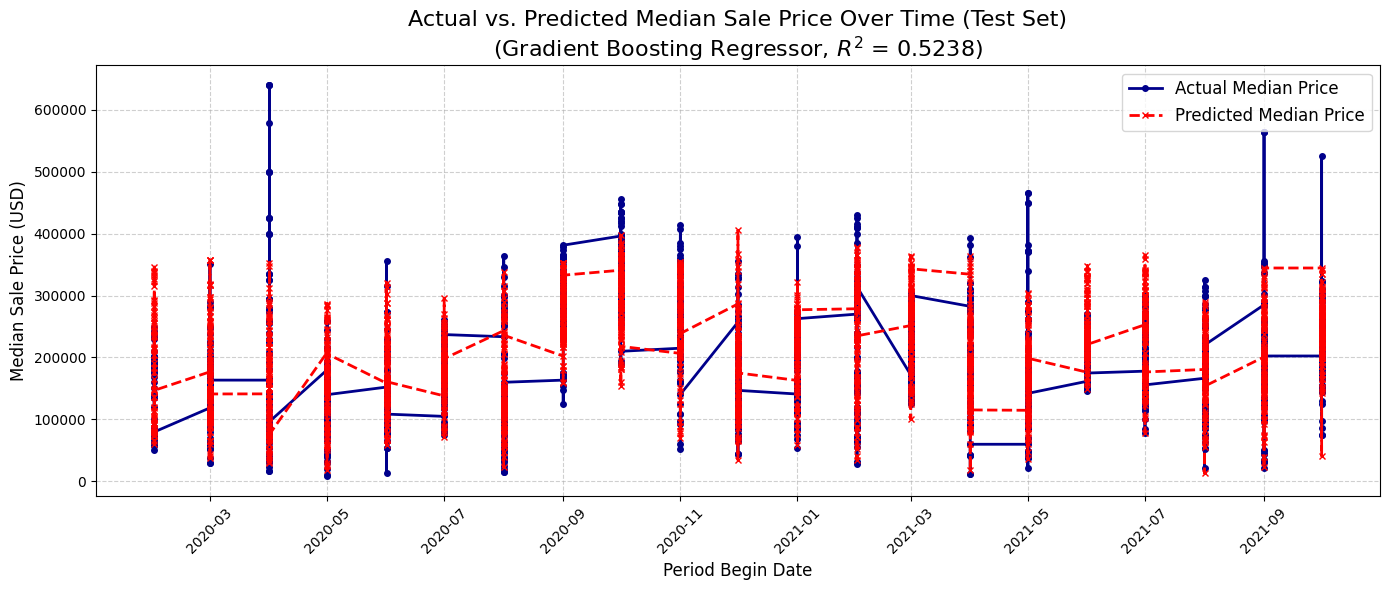

In [293]:
best_model = MODELS[best_model_name]
best_model.fit(X_train_final, y_train_final)
y_pred_log_final = best_model.predict(X_test_final)

# --- Visualization 1: Actual vs. Predicted Time Series Plot ---
test_dates = df.loc[test_index, 'period_begin'].reset_index(drop=True)
y_actual_price = np.exp(y_test_final)
y_predicted_price = np.exp(y_pred_log_final)
r2 = r2_score(y_test_final, y_pred_log_final)

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_actual_price, label='Actual Median Price', marker='o', linestyle='-', linewidth=2, markersize=4, color='darkblue')
plt.plot(test_dates, y_predicted_price, label='Predicted Median Price', marker='x', linestyle='--', linewidth=2, markersize=5, color='red')

plt.title(f'Actual vs. Predicted Median Sale Price Over Time (Test Set)\n(Gradient Boosting Regressor, $R^2$ = {r2:.4f})', fontsize=16)
plt.xlabel('Period Begin Date', fontsize=12)
plt.ylabel('Median Sale Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() # Use show() if running in a notebook cell

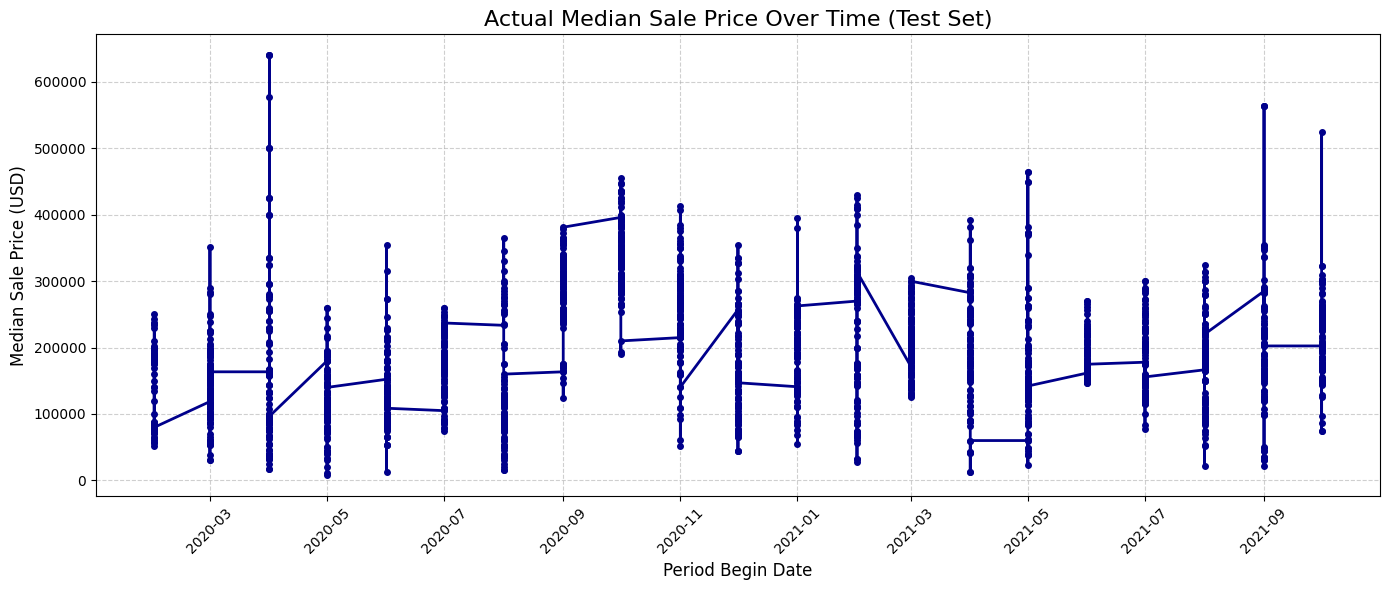

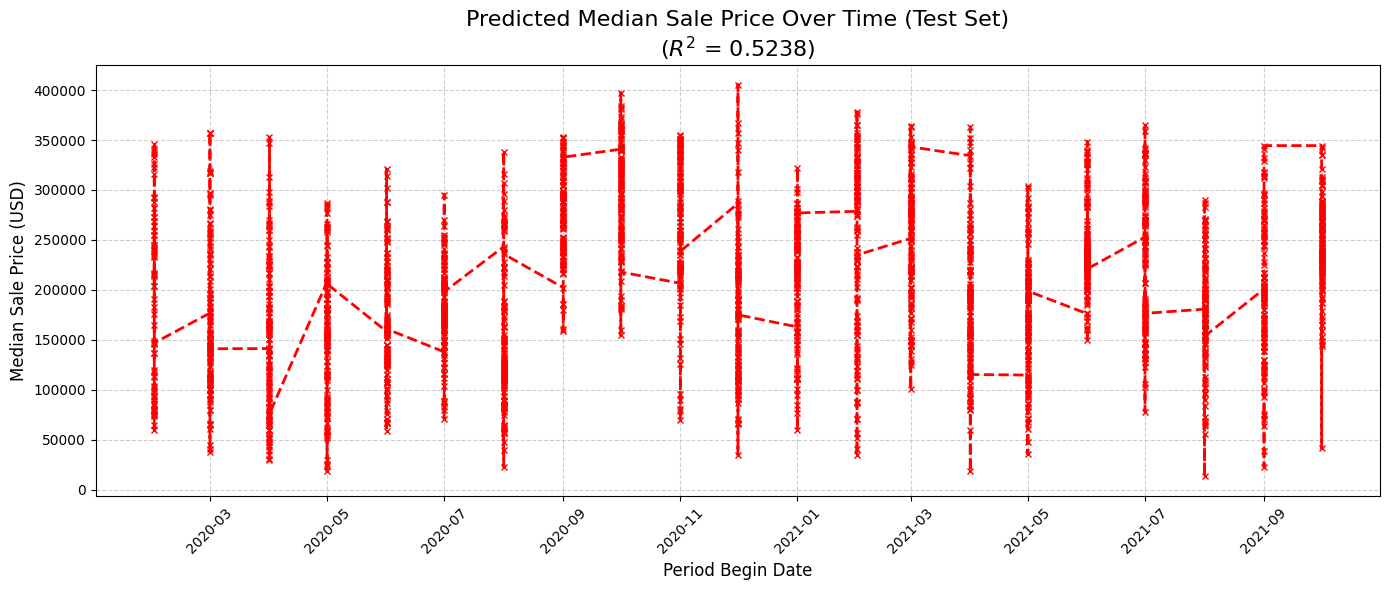

In [294]:
best_model = MODELS[best_model_name]
best_model.fit(X_train_final, y_train_final)
y_pred_log_final = best_model.predict(X_test_final)

# Prepare data
test_dates = df.loc[test_index, 'period_begin'].reset_index(drop=True)
y_actual_price = np.exp(y_test_final)
y_predicted_price = np.exp(y_pred_log_final)
r2 = r2_score(y_test_final, y_pred_log_final)

# --- Plot 1: Actual Median Price Time Series ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_actual_price, label='Actual Median Price',
         marker='o', linestyle='-', linewidth=2, markersize=4, color='darkblue')
plt.title('Actual Median Sale Price Over Time (Test Set)', fontsize=16)
plt.xlabel('Period Begin Date', fontsize=12)
plt.ylabel('Median Sale Price (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot 2: Predicted Median Price Time Series ---
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_predicted_price, label='Predicted Median Price',
         marker='x', linestyle='--', linewidth=2, markersize=5, color='red')
plt.title(f'Predicted Median Sale Price Over Time (Test Set)\n($R^2$ = {r2:.4f})', fontsize=16)
plt.xlabel('Period Begin Date', fontsize=12)
plt.ylabel('Median Sale Price (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [295]:

# Fit the best model on the final training set
best_model = MODELS[best_model_name]
best_model.fit(X_train_final, y_train_final)

# Final Metrics on the most recent test data (Test Period of the last fold)
y_pred_log_final = best_model.predict(X_test_final)
final_r2, final_mae, final_rmse = evaluate_regression_model(y_test_final, y_pred_log_final)

print(f"\n--- {best_model_name} Final Metrics on Latest Test Set ---")
print(f"R2 Score (log_price): {final_r2:.4f}")
print(f"MAE (median_sale_price): ${final_mae:,.2f}")
print(f"RMSE (median_sale_price): ${final_rmse:,.2f}")


--- Gradient Boosting Regressor Final Metrics on Latest Test Set ---
R2 Score (log_price): 0.5238
MAE (median_sale_price): $46,655.06
RMSE (median_sale_price): $64,721.74


<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/bl/4fb7d5n12kn_hx73_tsnfhhc0000gq/T/ipykernel_30989/1980795315.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(bins, y, 'r--', linewidth=2, label=f'Normal Fit ($\mu$={mu:.4f}, $\sigma$={sigma:.4f})')
/var/folders/bl/4fb7d5n12kn_hx73_tsnfhhc0000gq/T/ipykernel_30989/1980795315.py:22: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(bins, y, 'r--', linewidth=2, label=f'Normal Fit ($\mu$={mu:.4f}, $\sigma$={sigma:.4f})')


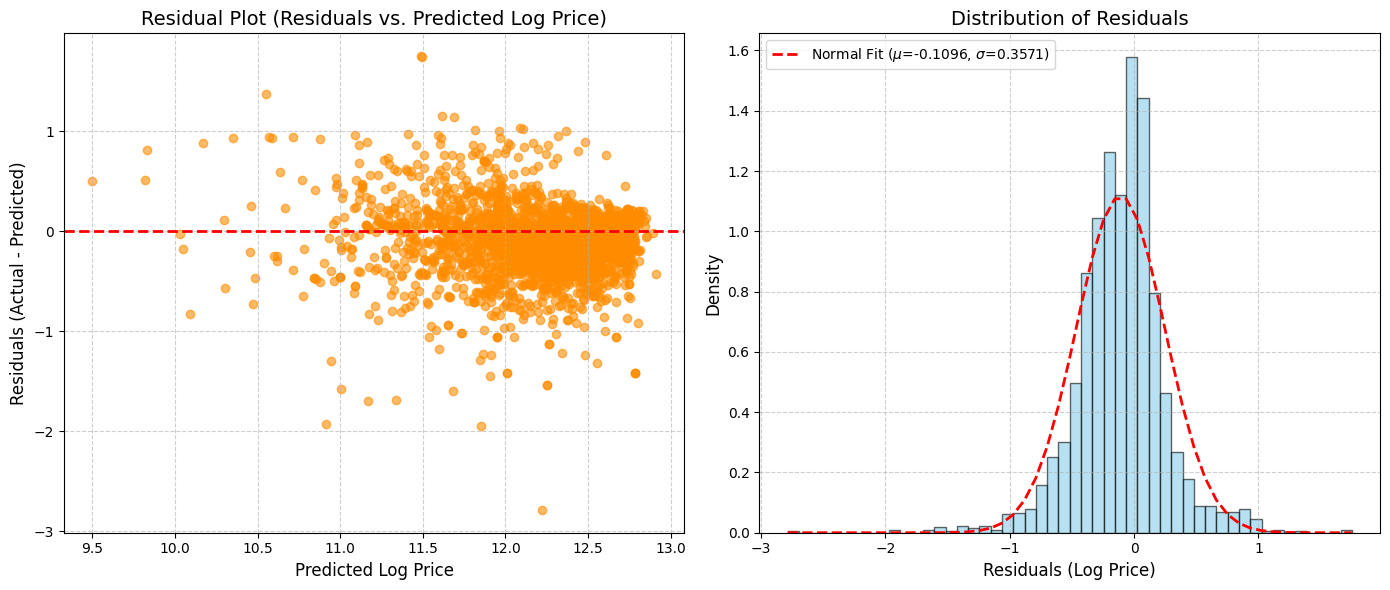

In [296]:
residuals = y_test_final - y_pred_log_final

plt.figure(figsize=(14, 6))

# Residuals vs. Predicted Values 
plt.subplot(1, 2, 1)
plt.scatter(y_pred_log_final, residuals, alpha=0.6, color='darkorange')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot (Residuals vs. Predicted Log Price)', fontsize=14)
plt.xlabel('Predicted Log Price', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)


plt.subplot(1, 2, 2)
# Calculate mean and standard deviation for the normal curve
(mu, sigma) = norm.fit(residuals)
n, bins, patches = plt.hist(residuals, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Plot the theoretical normal distribution curve
y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2, label=f'Normal Fit ($\mu$={mu:.4f}, $\sigma$={sigma:.4f})')

plt.title('Distribution of Residuals', fontsize=14)
plt.xlabel('Residuals (Log Price)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()

plt.show() 

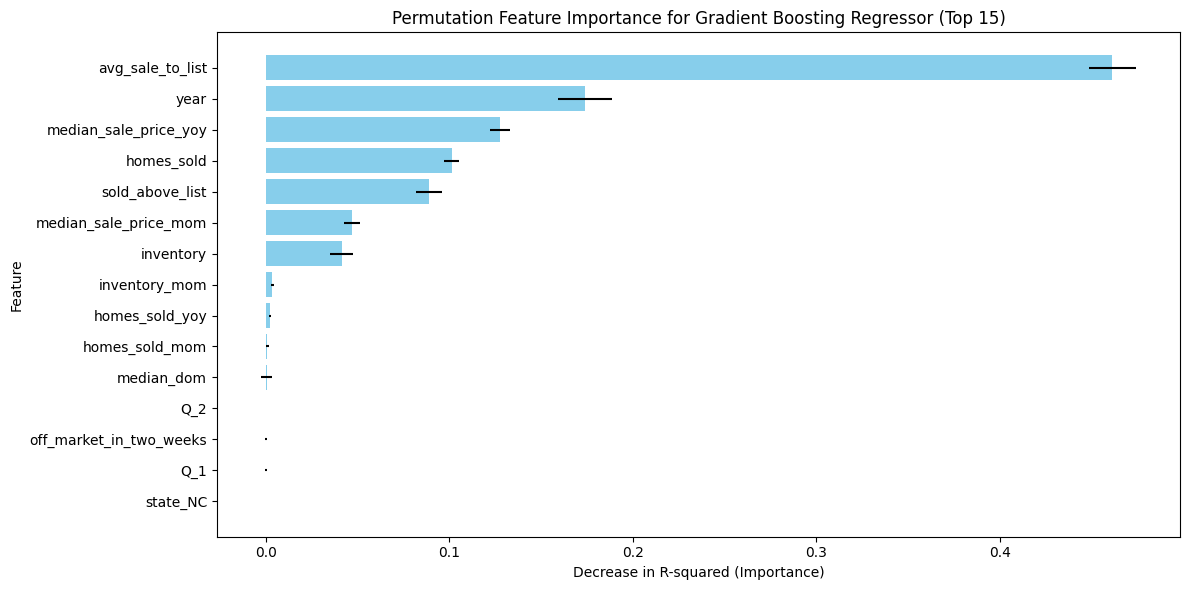

                  feature  importance       std
4        avg_sale_to_list    0.461509  0.012984
14                   year    0.174142  0.014623
7   median_sale_price_yoy    0.127539  0.005425
0              homes_sold    0.101369  0.004015
5         sold_above_list    0.089040  0.007006
6   median_sale_price_mom    0.046898  0.004385
1               inventory    0.041260  0.006360
10          inventory_mom    0.003388  0.000808
9          homes_sold_yoy    0.002261  0.000740
8          homes_sold_mom    0.000868  0.000674


In [297]:
r = permutation_importance(
    best_model, 
    X_test_final, 
    y_test_final, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1,
    scoring='r2'
)

# Create DataFrame and plot (Top 15 features)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': r.importances_mean,
    'std': r.importances_std
})

importance_df = importance_df.sort_values(by='importance', ascending=False).head(15)

# Plotting Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['feature'], importance_df['importance'], xerr=importance_df['std'], color='skyblue')
plt.gca().invert_yaxis()
plt.title(f'Permutation Feature Importance for {best_model_name} (Top 15)')
plt.xlabel('Decrease in R-squared (Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


print(importance_df.head(10))